In [1]:
# Program to find out if best of five sets are important:
#1) Scrape all data from 1970-2020
#2) Read a CSV file into a list of list
#3) Convert this into a dataframe
#4) Produce new columns with new data
#5) Plot results

In [2]:
from csv import reader
from itertools import zip_longest
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.optimize import curve_fit
from itertools import zip_longest

In [3]:
##### Get all the file names:
directory="Slam_Data2\\"
slam_names=[filename.split(".")[0] for filename in os.listdir(directory)] #Gets all files in a directory.

In [4]:
# Import all the slams and put the data into a data frame in a clean way:
col_names=['Grand Slam','Round','Player 1 Rating','Player 1','Player 1 Score','Player 2 Rating', 'Player 2','Player 2 Score']
sort_dict={'First Round':1,'Second Round':2,'Third Round':3,'Fourth Round':4,'Quarterfinals':5,'Semifinals':6,'Finals':7}
df=pd.DataFrame()
for slam_name in slam_names[75:]:
    df_temp=pd.read_csv(f"{directory}{slam_name}.csv", names=col_names) # read in next slam csv
    df_temp['Round']=df_temp['Round'].apply(lambda x: sort_dict[x]) # Replace round names with numbers (round 1-7)
    df_temp=df_temp.sort_values('Round',ascending=False) # Sort data frame in descending order of round (finals first)
    df = df.append(df_temp, ignore_index=True) # Append new slam data frame to main data frame
df['Player 1 Score']=df['Player 1 Score'].apply(lambda x: eval(x)) #Convert Player scores into a list of integers from a string.
df['Player 2 Score']=df['Player 2 Score'].apply(lambda x: eval(x))

In [5]:
def convert_rating(rating):
    '''Takes rating string in and returns an integer. If no rating, returns 100'''
    dig=''.join([num for num in rating if num.isdigit()])
    if not dig:
        return 100
    return int(dig)

In [6]:
df['Player 1 Rating']=df['Player 1 Rating'].apply(convert_rating)
df['Player 2 Rating']=df['Player 2 Rating'].apply(convert_rating)

In [7]:
df #Look at dataframe

,Grand Slam,Round,Player 1 Rating,Player 1,Player 1 Score,Player 2 Rating,Player 2,Player 2 Score
0,1989 a,7,9,Miloslav Mečíř,"[2, 2, 2]",2,Ivan Lendl,"[6, 6, 6]"
1,1989 a,6,11,Thomas Muster,"[2, 4, 7, 5]",2,Ivan Lendl,"[6, 6, 5, 7]"
2,1989 a,6,9,Miloslav Mečíř,"[7, 6, 6]",100,Jan Gunnarsson,"[5, 2, 2]"
3,1989 a,5,100,Goran Ivanišević,"[5, 0, 3]",9,Miloslav Mečíř,"[7, 6, 6]"
4,1989 a,5,14,Jonas Svensson,"[0, 3, 6, 4]",100,Jan Gunnarsson,"[6, 6, 4, 6]"
...,...,...,...,...,...,...,...,...
15870,2020 a,1,100,M Cecchinato,"[4, 64, 3]",7,A Zverev,"[6, 77, 6]"
15871,2020 a,1,100,C Ruud,"[3, 66, 6, 6, 66]",100,E Gerasimov,"[6, 78, 1, 4, 710]"
15872,2020 a,1,100,F Verdasco,"[7, 6, 6]",100,E Donskoy,"[5, 2, 1]"
15873,2020 a,1,26,N Basilashvili,"[65, 6, 7, 3, 6]",100,S-w Kwon,"[77, 4, 5, 6, 3]"


In [8]:
#Explore the data frame:
print(df['Round'].value_counts()) 
#There aren't enough round 4 given the number of round 5 I think due to when there were only 6 rounds in the tournaments, so we
#put some extra round 5 in there which were actually in the fourth round.
df.groupby('Round')['Player 1 Score'].apply(lambda x: len(x)).value_counts()
df_sets_by_round=pd.DataFrame()
for rounds in range(1,8):
    series=df[df['Round']==rounds]['Player 1 Score'].apply(lambda x: len(x)).value_counts()
    df_sets_by_round=pd.concat([df_sets_by_round,series],axis=1)
df_sets_by_round.columns=['Round 1','Round 2','Round 3','Round 4','Round 5','Round 6','Round 7']
df_sets_by_round=df_sets_by_round.iloc[3:,:]
df_sets_by_round

1    8000
2    4000
3    2000
4    1000
5     500
6     250
7     125
Name: Round, dtype: int64


,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7
3,3885,1904,984,477,239,119,53.0
4,2427,1255,608,316,151,79,49.0
5,1509,752,351,186,100,47,23.0


(10, 70)

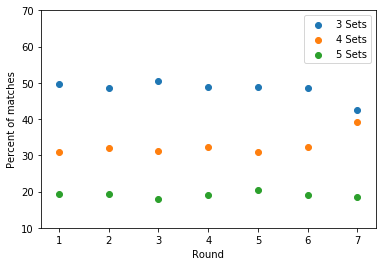

In [9]:
##### Plot percentage of matches as a function of round:
#Add percentages to data frame:
df_percent_sets=df_sets_by_round.copy()
for i, rounds in enumerate(range(1,8)):
    df_percent_sets[i+1]=df_percent_sets.iloc[:,i].apply(lambda x: x/df_percent_sets.iloc[:,i].sum())
df_percent_sets

#Plot them
for i in range(3):
    plt.scatter(x=np.arange(1,8),y=df_percent_sets.iloc[i,7:]*100)
plt.xlabel('Round')
plt.ylabel('Percent of matches')
plt.legend(('3 Sets','4 Sets','5 Sets'))
plt.ylim(10,70)

In [10]:
##### Figure out if players came back from 1 set to be up 2-1 and from 2 sets to be up 3-2:
# Function for 5 set comebacks:
def comeback(sets1,sets2,player1,player2,tournament):
    sets1=np.array(sets1)
    sets2=np.array(sets2)
    if len(sets1)<=4:
        return 0
    if len(sets1)>len(sets2):# or any(sets1==sets2):
        sets1[4]=6
        sets2=np.append(sets2,0)
    elif len(sets1)<len(sets2):
        sets1=np.append(sets1,0)
        sets2[4]=6
    if len(sets1)==5:
        sets_truthy=sets1>sets2
        sets_truthy2=sets2>sets1
        if np.sum(sets_truthy[0:3])==2 and np.sum(sets_truthy)==2:
            return -1
        elif np.sum(sets_truthy2[0:3])==2 and np.sum(sets_truthy2)==2:
            return 1
        else:
            return 0

In [11]:
##test function comeback.
a=[0,6,6,6,6]
b=[6,0,0,0,0]
a=np.array(a)
b=np.array(b)
f=df.iloc[0,:]
comeback(a,b,f[2],f[4],f[0])

0

In [12]:
df['5-set Comeback']=df.apply(lambda x: comeback(x['Player 1 Score'],x['Player 2 Score'],x['Player 1'],x['Player 2'],x['Grand Slam']), axis=1)

In [13]:
# Function for 3 set comebacks now:
def comeback3(sets1,sets2,player1,player2,tournament):
    sets1=np.array(sets1)
    sets2=np.array(sets2)
    if len(sets1)<=2:
        return 0
    if len(sets1)>len(sets2):#Fix the injured players.
        sets1[-1]=6
        sets2=np.append(sets2,0)
    elif len(sets1)<len(sets2):
        sets1=np.append(sets1,0)
        sets2[-1]=6
    sets_truthy=sets1>sets2
    sets_truthy2=sets2>sets1
    if np.sum(sets_truthy[0])==1 and np.sum(sets_truthy[0:3])==1:
        return -1
    elif np.sum(sets_truthy2[0])==1 and np.sum(sets_truthy2[0:3])==1:
        return 1
    else:
        return 0

In [14]:
comeback3(a,b,f[2],f[4],f[0]) #test 3 set comeback function

1

In [15]:
df['3-set Comeback']=df.apply(lambda x: comeback3(x['Player 1 Score'],x['Player 2 Score'],x['Player 1'],x['Player 2'],x['Grand Slam']), axis=1)

In [16]:
##### Which player won? 1 or 2? 1 is player 1, -1 is player 2.
def win(score1,score2):
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)>len(score2):
        return 1
    elif len(score1)<len(score2):
        return -1
    elif len(score1)==0 or len(score2)==0:
        return 0
    elif score1[-1]>score2[-1]:
        return 1
    elif score1[-1]<score2[-1]:
        return -1

In [17]:
win([2, 2, 2],[6, 6, 6])#test win function:

-1

In [18]:
df['Winner']=df.apply(lambda x: win(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [19]:
df.drop(df[df['Winner']==0].index,inplace=True) #Get rid of any matches where one of the player has no score.

In [20]:
#Make column which shows if higher or lower rated player wins. Returns 1 if higher rated wins, -1 if lower rated wins and 0 if they are equally rated.
def rated_winner(rate1,rate2,winner):
    if rate1==rate2:
        return 0
    elif rate1<rate2 and winner==1:
        return 1
    elif rate1>rate2 and winner==-1:
        return 1
    return -1

In [21]:
#test rated_winner function:
rated_winner(10,1,-1)

1

In [22]:
#Make new column with Rated winner:
df['Rated Winner']=df.apply(lambda x: rated_winner(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner']),axis=1)

In [23]:
######Which player won in 3 sets? 1 or 2? 1 is player 1, -1 is player 2.

def win3(score1,score2):
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<2 or len(score2)<2: #deal with injuries before 2 sets could be played
        if len(score1)>len(score2):
            return 1
        elif len(score1)<len(score2):
            return -1
    if len(score1)>len(score2): #for matches with injuries with 2 sets played, and the player retires in set 3,4 or 5, make that player's last set=-1
        score2=np.append(score2,-1)
    elif len(score1)<len(score2):
        score1=np.append(score1,-1)
    true_score3=score1>score2 #Compare matches with 2 or more sets.
    if len(true_score3)==2: #Matches with 2 sets, compare only first two sets scores.
        if sum(true_score3)==2:
            return 1
        return -1
    if sum(true_score3[0:3])>=2: #Matches with 3,4, or 5 sets, compare first 3 sets scores.
        return 1
    return -1
    
    
#test win3 function:
win3([2,6,2,6],[6,0,6,0,0])
win3([6,6,6],[0,0,0])
win3([2,6,2,6,6],[6,0,6,0,0])
win3([6,6],[0,0,4])

1

In [24]:
df['Winner 3']=df.apply(lambda x: win3(x['Player 1 Score'],x['Player 2 Score']),axis=1)

#Make column which shows if higher or lower rated player wins. Returns 1 if higher rated wins, -1 if lower rated wins and 0 if they are equally rated.
def rated_winner3(rate1,rate2,winner):
    if rate1==rate2:
        return 0
    elif rate1<rate2 and winner==1:
        return 1
    elif rate1>rate2 and winner==-1:
        return 1
    return -1

#test rated_winner function:
rated_winner(10,1,-1)

#Make new column with Rated winner:
df['Rated Winner 3']=df.apply(lambda x: rated_winner3(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner 3']),axis=1)

In [25]:
def match_length(score1,score2):
    return max(len(score1),len(score2))
match_length([2, 4, 7, 5],[3, 4, 6, 6, 6]) #test match_length

5

In [26]:
df['# of Sets']=df.apply(lambda x: match_length(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [27]:
#Which player won in 3 sets and how many sets would it have taked? 1 or 2? 1 is player 1, -1 is player 2.
def match_length3(score1,score2):
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<2 or len(score2)<2: #deal with injuries before 2 sets could be played
        if len(score1)>len(score2):
            return max(len(score1),len(score2))
        elif len(score1)<len(score2):
            return max(len(score1),len(score2))
    if len(score1)>len(score2): #for matches with injuries with 2 sets played, and the player retires in set 3,4 or 5, make that player's last set=-1
        score2=np.append(score2,-1)
    elif len(score1)<len(score2):
        score1=np.append(score1,-1)
    true_score3=score1>score2 #Compare matches with 2 or more sets.
    if len(true_score3)<2:
        return len(true_score3)
    elif len(true_score3)==2: #Matches with 2 sets, compare only first two sets scores.
        if sum(true_score3)==2:
            return 2
        return 2
    if sum(true_score3[0:3])>=2: #Matches with 3,4, or 5 sets, compare first 3 sets scores.
        if true_score3[0]!=true_score3[1]:
            return 3
        else:
            return 2
    else:
        if true_score3[0]!=true_score3[1]:
            return 3
        else:
            return 2
    
    
#test match_length3 function:
print(match_length3([2,6,2,6],[6,0,6,0,0]))
print(match_length3([6,6,6],[0,0,0]))
print(match_length3([2,6,2,6,6],[6,0,6,0,0]))
print(match_length3([6,6],[0,0,4]))
print(match_length3([6,4],[0]))

3
2
3
2
2


In [28]:
df['# of Sets 3']=df.apply(lambda x: match_length3(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [29]:
#How many comebacks are done by higher rated and by lower rated players?
#If the higher player made a 5-set comeback, return 1, lower rated player return -1, equal rated return 0.
def rated_comeback5(rate1,rate2,comeback5):
    if rate1==rate2 or comeback5==0:
        return 0
    elif rate1<rate2 and comeback5==1:
        return 1
    elif rate1>rate2 and comeback5==-1:
        return 1
    return -1
rated_comeback5(1,10,-1) #tested all 5 scenarios.

-1

In [30]:
df['Rated 5-set Comeback']=df.apply(lambda x: rated_comeback5(x['Player 1 Rating'],x['Player 2 Rating'],x['5-set Comeback']),axis=1)

In [31]:
#How many comebacks are done by higher rated and by lower rated players in 3 sets?
#If the higher player made a 3-set comeback, return 1, lower rated player return -1, equal rated return 0.
def rated_comeback3(rate1,rate2,comeback3):
    if rate1==rate2 or comeback3==0:
        return 0
    elif rate1<rate2 and comeback3==1:
        return 1
    elif rate1>rate2 and comeback3==-1:
        return 1
    return -1
rated_comeback5(1,10,-1) #tested all 5 scenarios.

-1

In [32]:
df['Rated 3-set Comeback']=df.apply(lambda x: rated_comeback3(x['Player 1 Rating'],x['Player 2 Rating'],x['3-set Comeback']),axis=1)

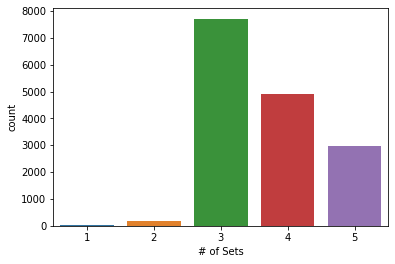

In [33]:
#Set Breakdown for all players. First look
sns.countplot(x='# of Sets',data=df)

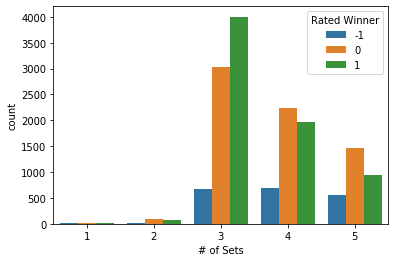

In [34]:
#Look at set breakdown for rated vs non-rated players:
sns.countplot(x='# of Sets',data=df,hue='Rated Winner')

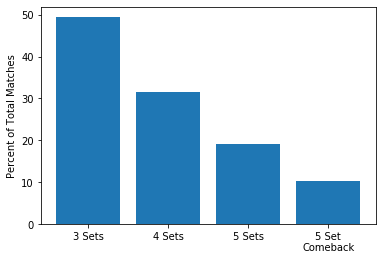

[49.42307692 31.43589744 19.14102564 10.37820513]


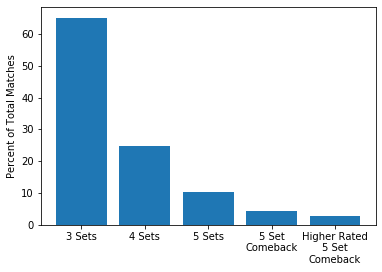

[65.19174041 24.63126844 10.17699115  4.42477876  2.80235988]


1.726263871763255

In [35]:
######## Plot distribution of all players and #1 rated player (with rated comebacks for rated player)

#Plot distribution of sets for entire tournament again:
xticks=['3 Sets', '4 Sets', '5 Sets', '5 Set\nComeback', 'Higher Rated\n5 Set\nComeback']
sets_dist=df['# of Sets'].value_counts()[0:3].values
comeback_5sets=len(df[df['5-set Comeback']!=0])
sets_comeback_dist=np.append(sets_dist,comeback_5sets)/sum(sets_dist)*100
plt.bar(np.arange(4),height=sets_comeback_dist)
plt.xticks(np.arange(4),labels=xticks[0:4])
plt.ylabel('Percent of Total Matches')
plt.show()
print(sets_comeback_dist)

# Plot distribution of sets for #1 rated player:
df_1=df[df['Player 1 Rating']==1]
sets_dist_1=df_1['# of Sets'].value_counts()[0:3].values
comeback_5sets_all=len(df_1[df_1['5-set Comeback']!=0])
comeback_5sets_1=len(df_1[df_1['5-set Comeback']==1])
sets_comeback_dist_1=np.append(sets_dist_1,[comeback_5sets_all,comeback_5sets_1])/sum(sets_dist_1)*100
plt.bar(np.arange(5),height=sets_comeback_dist_1)
plt.xticks(np.arange(5),labels=xticks)
plt.ylabel('Percent of Total Matches')
plt.show()
print(sets_comeback_dist_1)

# 5 set comebacks win to loss percentage for #1 seed:
2.80/1.622

In [36]:
##### Make a new data frame with the distribution of matches for players of different ratings.
# Plot all of the  difference in percentages for each seed:
dist_ratings=np.empty((0,7), float)
#First loop through player 1, then through player 2, then add totals.
for rating in range(1,33):
    df_1=df[df['Player 1 Rating']==rating]
    if df_1.empty:
        dist_ratings=np.append(dist_ratings,[np.zeros(7)],axis=0) #Because there are no games in the player 1 rating column for the #2 seed.
    else:
        sets_dist_1=df_1['# of Sets'].value_counts()[0:3].values
        comeback_5sets_all=len(df_1[df_1['5-set Comeback']!=0])
        comeback_5sets_1=len(df_1[df_1['5-set Comeback']==1])
        comeback_5sets_lose=len(df_1[df_1['5-set Comeback']==-1])
        diff=comeback_5sets_1-comeback_5sets_lose
        sets_comeback_dist_1=np.append(sets_dist_1,[comeback_5sets_all,comeback_5sets_1,comeback_5sets_lose,diff])
        sets_comeback_dist_1_perc=sets_comeback_dist_1/sum(sets_dist_1)*100
        dist_ratings=np.append(dist_ratings,[sets_comeback_dist_1],axis=0)

df_dist_ratings=pd.DataFrame(dist_ratings)
df_dist_ratings.columns=['3 Set Matches','4 Set Matches','5 Set Matches','5 Set Comebacks','5 Set Comeback Win','5 Set Comeback Loss','5 Set Comeback Diff']

#Do the exact same thing as above, but for the player 2 rating, and then add the values together to aggregate all the data.
dist_ratings2=np.empty((0,7), float)
for rating in range(1,33):
    df_1=df[df['Player 2 Rating']==rating]
    if df_1.empty:
        dist_ratings2=np.append(dist_ratings2,[np.zeros(7)],axis=0) #Because there are no games in the player 2 rating column for the #1 seed.
    else:
        sets_dist_1=df_1['# of Sets'].value_counts()[0:3].values
        comeback_5sets_all=len(df_1[df_1['5-set Comeback']!=0])
        comeback_5sets_1=len(df_1[df_1['5-set Comeback']==-1])
        comeback_5sets_lose=len(df_1[df_1['5-set Comeback']==1])
        diff=comeback_5sets_1-comeback_5sets_lose
        sets_comeback_dist_1=np.append(sets_dist_1,[comeback_5sets_all,comeback_5sets_1,comeback_5sets_lose,diff])
        sets_comeback_dist_1_perc=sets_comeback_dist_1/sum(sets_dist_1)*100
        dist_ratings2=np.append(dist_ratings2,[sets_comeback_dist_1],axis=0)

df_dist_ratings2=pd.DataFrame(dist_ratings2)
df_dist_ratings2.columns=['3 Set Matches','4 Set Matches','5 Set Matches','5 Set Comebacks','5 Set Comeback Win','5 Set Comeback Loss','5 Set Comeback Diff']

df_dist_ratings_all = df_dist_ratings.add(df_dist_ratings2, fill_value=0)
df_dist_ratings_all['Rating']=np.arange(1,33)

#Make new columns for all of these with percentages rather than absolute values:
for sets_name in df_dist_ratings_all.columns[0:7]:
    df_dist_ratings_all[f'Percent {sets_name}']=df_dist_ratings_all.apply(lambda x: x[sets_name]/(x['3 Set Matches']+x['4 Set Matches']+x['5 Set Matches'])*100,axis=1)
df_dist_ratings_all #See new dataframe

,3 Set Matches,4 Set Matches,5 Set Matches,5 Set Comebacks,5 Set Comeback Win,5 Set Comeback Loss,5 Set Comeback Diff,Rating,Percent 3 Set Matches,Percent 4 Set Matches,Percent 5 Set Matches,Percent 5 Set Comebacks,Percent 5 Set Comeback Win,Percent 5 Set Comeback Loss,Percent 5 Set Comeback Diff
0,442.0,167.0,69.0,30.0,19.0,11.0,8.0,1,65.191740,24.631268,10.176991,4.424779,2.802360,1.622419,1.179941
1,396.0,157.0,87.0,43.0,33.0,10.0,23.0,2,61.875000,24.531250,13.593750,6.718750,5.156250,1.562500,3.593750
2,326.0,188.0,83.0,50.0,34.0,16.0,18.0,3,54.606365,31.490787,13.902848,8.375209,5.695142,2.680067,3.015075
3,305.0,149.0,75.0,43.0,29.0,14.0,15.0,4,57.655955,28.166352,14.177694,8.128544,5.482042,2.646503,2.835539
4,242.0,124.0,74.0,40.0,26.0,14.0,12.0,5,55.000000,28.181818,16.818182,9.090909,5.909091,3.181818,2.727273
5,249.0,136.0,80.0,46.0,28.0,18.0,10.0,6,53.548387,29.247312,17.204301,9.892473,6.021505,3.870968,2.150538
6,227.0,145.0,74.0,42.0,28.0,14.0,14.0,7,50.896861,32.511211,16.591928,9.417040,6.278027,3.139013,3.139013
7,204.0,112.0,77.0,37.0,19.0,18.0,1.0,8,51.908397,28.498728,19.592875,9.414758,4.834606,4.580153,0.254453
8,209.0,147.0,85.0,48.0,31.0,17.0,14.0,9,47.392290,33.333333,19.274376,10.884354,7.029478,3.854875,3.174603
9,220.0,137.0,71.0,40.0,21.0,19.0,2.0,10,51.401869,32.009346,16.588785,9.345794,4.906542,4.439252,0.467290


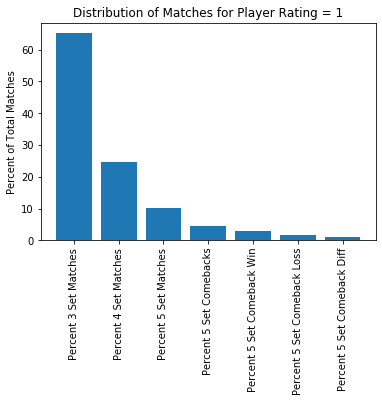

Percent 3 Set Matches          65.191740
Percent 4 Set Matches          24.631268
Percent 5 Set Matches          10.176991
Percent 5 Set Comebacks         4.424779
Percent 5 Set Comeback Win      2.802360
Percent 5 Set Comeback Loss     1.622419
Percent 5 Set Comeback Diff     1.179941
Name: 0, dtype: float64


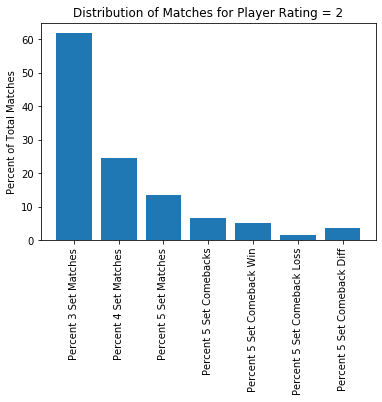

Percent 3 Set Matches          61.87500
Percent 4 Set Matches          24.53125
Percent 5 Set Matches          13.59375
Percent 5 Set Comebacks         6.71875
Percent 5 Set Comeback Win      5.15625
Percent 5 Set Comeback Loss     1.56250
Percent 5 Set Comeback Diff     3.59375
Name: 1, dtype: float64


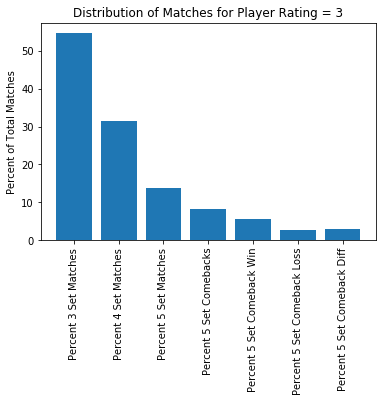

Percent 3 Set Matches          54.606365
Percent 4 Set Matches          31.490787
Percent 5 Set Matches          13.902848
Percent 5 Set Comebacks         8.375209
Percent 5 Set Comeback Win      5.695142
Percent 5 Set Comeback Loss     2.680067
Percent 5 Set Comeback Diff     3.015075
Name: 2, dtype: float64


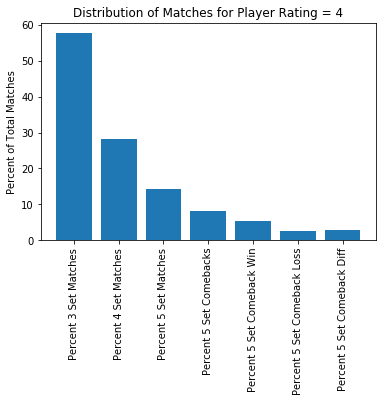

Percent 3 Set Matches          57.655955
Percent 4 Set Matches          28.166352
Percent 5 Set Matches          14.177694
Percent 5 Set Comebacks         8.128544
Percent 5 Set Comeback Win      5.482042
Percent 5 Set Comeback Loss     2.646503
Percent 5 Set Comeback Diff     2.835539
Name: 3, dtype: float64


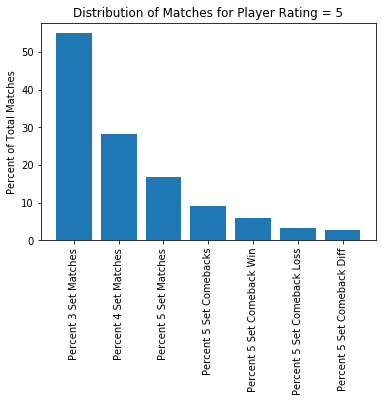

Percent 3 Set Matches          55.000000
Percent 4 Set Matches          28.181818
Percent 5 Set Matches          16.818182
Percent 5 Set Comebacks         9.090909
Percent 5 Set Comeback Win      5.909091
Percent 5 Set Comeback Loss     3.181818
Percent 5 Set Comeback Diff     2.727273
Name: 4, dtype: float64


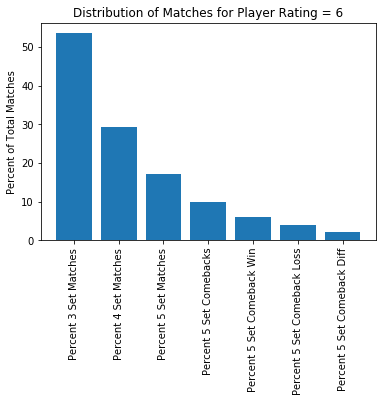

Percent 3 Set Matches          53.548387
Percent 4 Set Matches          29.247312
Percent 5 Set Matches          17.204301
Percent 5 Set Comebacks         9.892473
Percent 5 Set Comeback Win      6.021505
Percent 5 Set Comeback Loss     3.870968
Percent 5 Set Comeback Diff     2.150538
Name: 5, dtype: float64


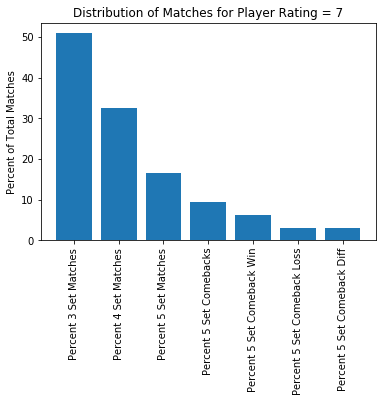

Percent 3 Set Matches          50.896861
Percent 4 Set Matches          32.511211
Percent 5 Set Matches          16.591928
Percent 5 Set Comebacks         9.417040
Percent 5 Set Comeback Win      6.278027
Percent 5 Set Comeback Loss     3.139013
Percent 5 Set Comeback Diff     3.139013
Name: 6, dtype: float64


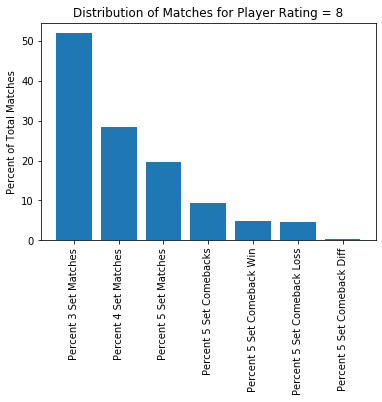

Percent 3 Set Matches          51.908397
Percent 4 Set Matches          28.498728
Percent 5 Set Matches          19.592875
Percent 5 Set Comebacks         9.414758
Percent 5 Set Comeback Win      4.834606
Percent 5 Set Comeback Loss     4.580153
Percent 5 Set Comeback Diff     0.254453
Name: 7, dtype: float64


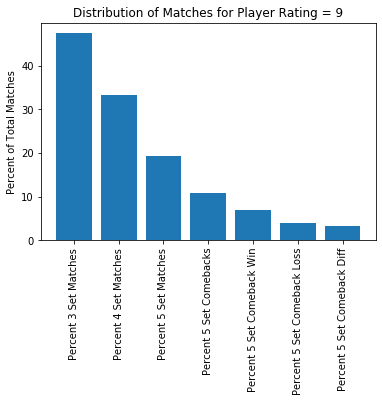

Percent 3 Set Matches          47.392290
Percent 4 Set Matches          33.333333
Percent 5 Set Matches          19.274376
Percent 5 Set Comebacks        10.884354
Percent 5 Set Comeback Win      7.029478
Percent 5 Set Comeback Loss     3.854875
Percent 5 Set Comeback Diff     3.174603
Name: 8, dtype: float64


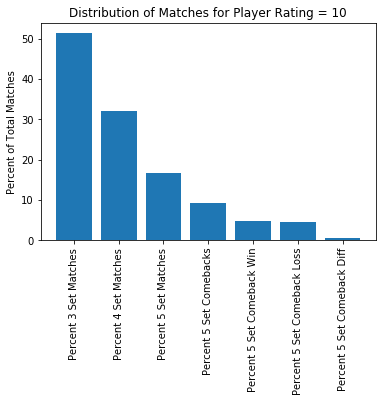

Percent 3 Set Matches          51.401869
Percent 4 Set Matches          32.009346
Percent 5 Set Matches          16.588785
Percent 5 Set Comebacks         9.345794
Percent 5 Set Comeback Win      4.906542
Percent 5 Set Comeback Loss     4.439252
Percent 5 Set Comeback Diff     0.467290
Name: 9, dtype: float64


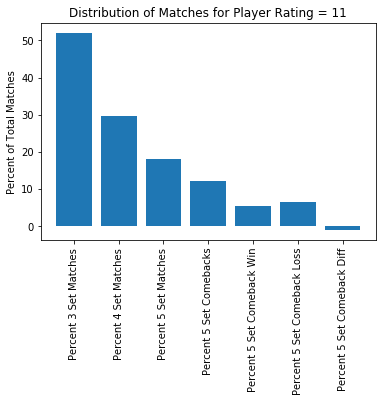

Percent 3 Set Matches          52.066116
Percent 4 Set Matches          29.752066
Percent 5 Set Matches          18.181818
Percent 5 Set Comebacks        12.121212
Percent 5 Set Comeback Win      5.509642
Percent 5 Set Comeback Loss     6.611570
Percent 5 Set Comeback Diff    -1.101928
Name: 10, dtype: float64


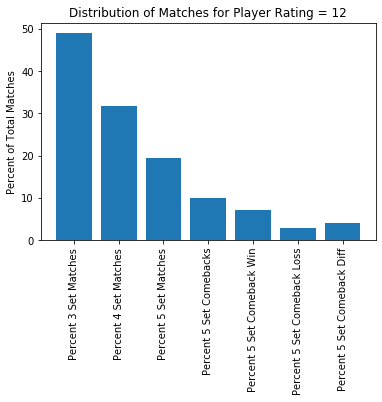

Percent 3 Set Matches          48.974943
Percent 4 Set Matches          31.662870
Percent 5 Set Matches          19.362187
Percent 5 Set Comebacks        10.022779
Percent 5 Set Comeback Win      7.061503
Percent 5 Set Comeback Loss     2.961276
Percent 5 Set Comeback Diff     4.100228
Name: 11, dtype: float64


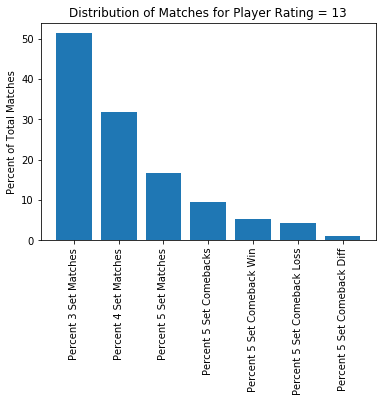

Percent 3 Set Matches          51.329787
Percent 4 Set Matches          31.914894
Percent 5 Set Matches          16.755319
Percent 5 Set Comebacks         9.574468
Percent 5 Set Comeback Win      5.319149
Percent 5 Set Comeback Loss     4.255319
Percent 5 Set Comeback Diff     1.063830
Name: 12, dtype: float64


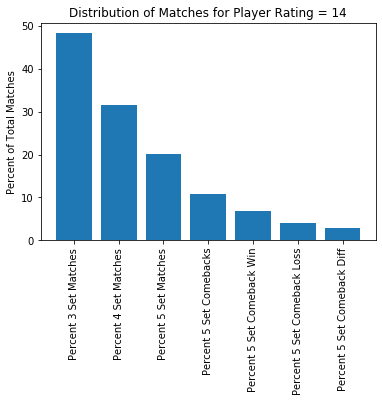

Percent 3 Set Matches          48.293963
Percent 4 Set Matches          31.496063
Percent 5 Set Matches          20.209974
Percent 5 Set Comebacks        10.761155
Percent 5 Set Comeback Win      6.824147
Percent 5 Set Comeback Loss     3.937008
Percent 5 Set Comeback Diff     2.887139
Name: 13, dtype: float64


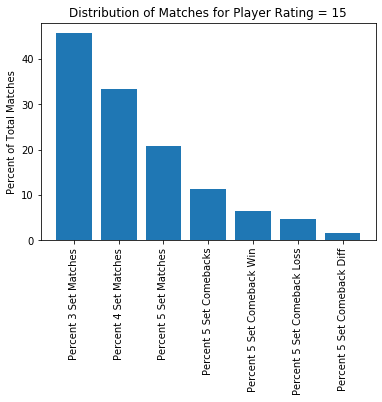

Percent 3 Set Matches          45.721925
Percent 4 Set Matches          33.422460
Percent 5 Set Matches          20.855615
Percent 5 Set Comebacks        11.229947
Percent 5 Set Comeback Win      6.417112
Percent 5 Set Comeback Loss     4.812834
Percent 5 Set Comeback Diff     1.604278
Name: 14, dtype: float64


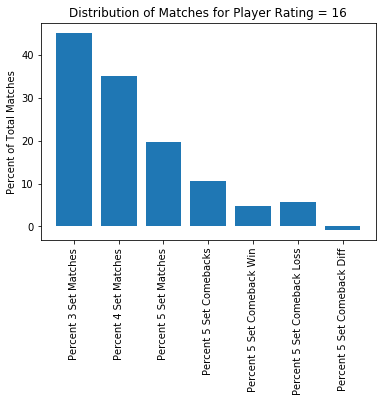

Percent 3 Set Matches          45.222930
Percent 4 Set Matches          35.031847
Percent 5 Set Matches          19.745223
Percent 5 Set Comebacks        10.509554
Percent 5 Set Comeback Win      4.777070
Percent 5 Set Comeback Loss     5.732484
Percent 5 Set Comeback Diff    -0.955414
Name: 15, dtype: float64


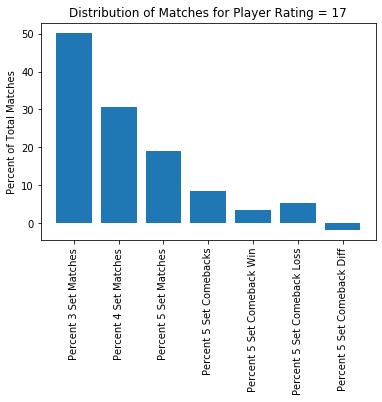

Percent 3 Set Matches          50.239234
Percent 4 Set Matches          30.622010
Percent 5 Set Matches          19.138756
Percent 5 Set Comebacks         8.612440
Percent 5 Set Comeback Win      3.349282
Percent 5 Set Comeback Loss     5.263158
Percent 5 Set Comeback Diff    -1.913876
Name: 16, dtype: float64


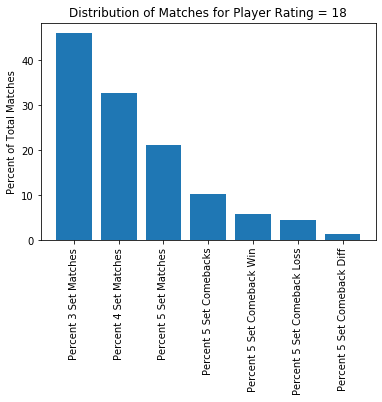

Percent 3 Set Matches          46.039604
Percent 4 Set Matches          32.673267
Percent 5 Set Matches          21.287129
Percent 5 Set Comebacks        10.396040
Percent 5 Set Comeback Win      5.940594
Percent 5 Set Comeback Loss     4.455446
Percent 5 Set Comeback Diff     1.485149
Name: 17, dtype: float64


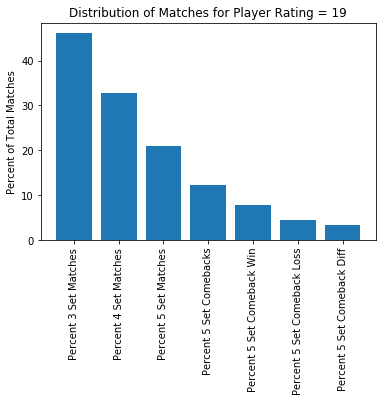

Percent 3 Set Matches          46.078431
Percent 4 Set Matches          32.843137
Percent 5 Set Matches          21.078431
Percent 5 Set Comebacks        12.254902
Percent 5 Set Comeback Win      7.843137
Percent 5 Set Comeback Loss     4.411765
Percent 5 Set Comeback Diff     3.431373
Name: 18, dtype: float64


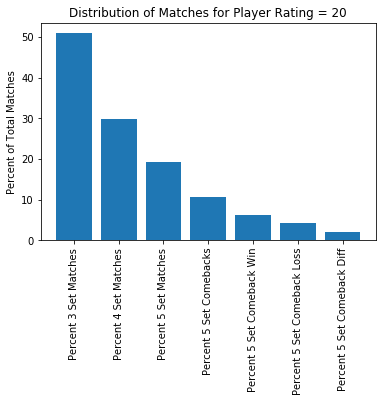

Percent 3 Set Matches          50.961538
Percent 4 Set Matches          29.807692
Percent 5 Set Matches          19.230769
Percent 5 Set Comebacks        10.576923
Percent 5 Set Comeback Win      6.250000
Percent 5 Set Comeback Loss     4.326923
Percent 5 Set Comeback Diff     1.923077
Name: 19, dtype: float64


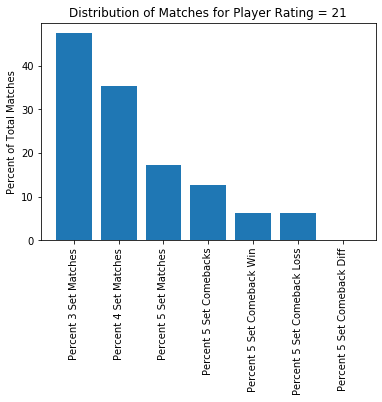

Percent 3 Set Matches          47.428571
Percent 4 Set Matches          35.428571
Percent 5 Set Matches          17.142857
Percent 5 Set Comebacks        12.571429
Percent 5 Set Comeback Win      6.285714
Percent 5 Set Comeback Loss     6.285714
Percent 5 Set Comeback Diff     0.000000
Name: 20, dtype: float64


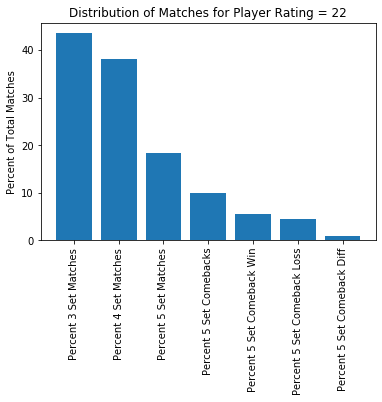

Percent 3 Set Matches          43.564356
Percent 4 Set Matches          38.118812
Percent 5 Set Matches          18.316832
Percent 5 Set Comebacks         9.900990
Percent 5 Set Comeback Win      5.445545
Percent 5 Set Comeback Loss     4.455446
Percent 5 Set Comeback Diff     0.990099
Name: 21, dtype: float64


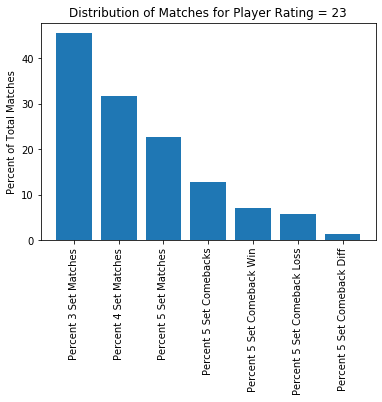

Percent 3 Set Matches          45.497630
Percent 4 Set Matches          31.753555
Percent 5 Set Matches          22.748815
Percent 5 Set Comebacks        12.796209
Percent 5 Set Comeback Win      7.109005
Percent 5 Set Comeback Loss     5.687204
Percent 5 Set Comeback Diff     1.421801
Name: 22, dtype: float64


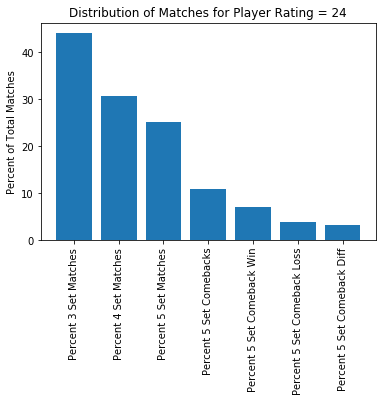

Percent 3 Set Matches          44.075829
Percent 4 Set Matches          30.805687
Percent 5 Set Matches          25.118483
Percent 5 Set Comebacks        10.900474
Percent 5 Set Comeback Win      7.109005
Percent 5 Set Comeback Loss     3.791469
Percent 5 Set Comeback Diff     3.317536
Name: 23, dtype: float64


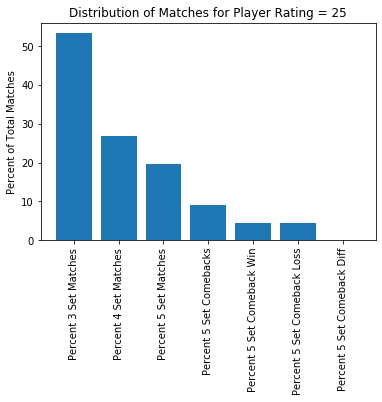

Percent 3 Set Matches          53.370787
Percent 4 Set Matches          26.966292
Percent 5 Set Matches          19.662921
Percent 5 Set Comebacks         8.988764
Percent 5 Set Comeback Win      4.494382
Percent 5 Set Comeback Loss     4.494382
Percent 5 Set Comeback Diff     0.000000
Name: 24, dtype: float64


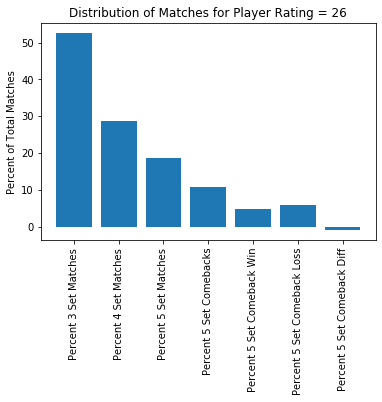

Percent 3 Set Matches          52.659574
Percent 4 Set Matches          28.723404
Percent 5 Set Matches          18.617021
Percent 5 Set Comebacks        10.638298
Percent 5 Set Comeback Win      4.787234
Percent 5 Set Comeback Loss     5.851064
Percent 5 Set Comeback Diff    -1.063830
Name: 25, dtype: float64


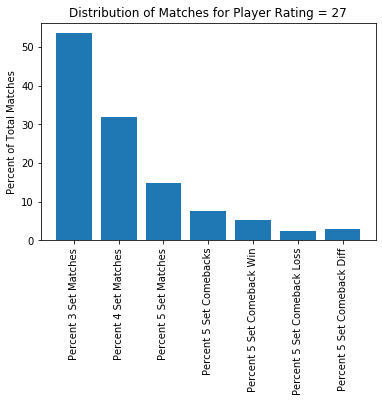

Percent 3 Set Matches          53.529412
Percent 4 Set Matches          31.764706
Percent 5 Set Matches          14.705882
Percent 5 Set Comebacks         7.647059
Percent 5 Set Comeback Win      5.294118
Percent 5 Set Comeback Loss     2.352941
Percent 5 Set Comeback Diff     2.941176
Name: 26, dtype: float64


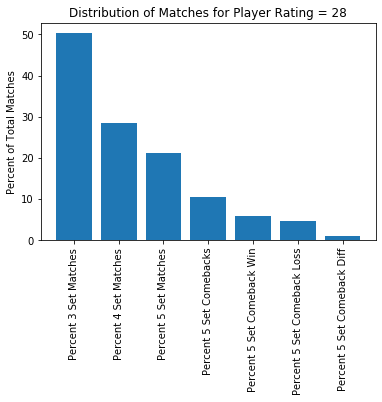

Percent 3 Set Matches          50.264550
Percent 4 Set Matches          28.571429
Percent 5 Set Matches          21.164021
Percent 5 Set Comebacks        10.582011
Percent 5 Set Comeback Win      5.820106
Percent 5 Set Comeback Loss     4.761905
Percent 5 Set Comeback Diff     1.058201
Name: 27, dtype: float64


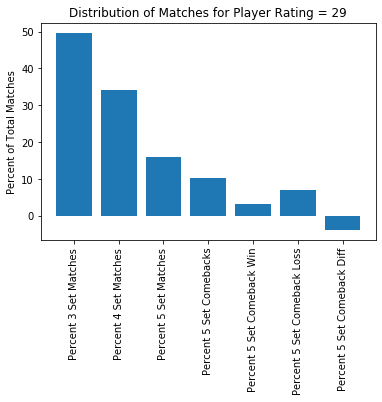

Percent 3 Set Matches          49.677419
Percent 4 Set Matches          34.193548
Percent 5 Set Matches          16.129032
Percent 5 Set Comebacks        10.322581
Percent 5 Set Comeback Win      3.225806
Percent 5 Set Comeback Loss     7.096774
Percent 5 Set Comeback Diff    -3.870968
Name: 28, dtype: float64


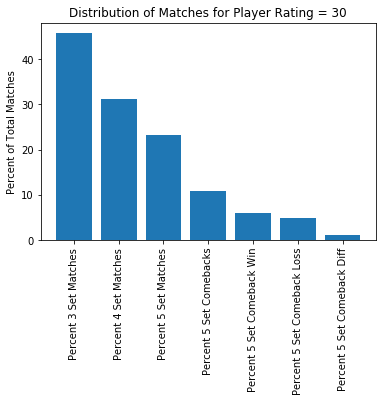

Percent 3 Set Matches          45.731707
Percent 4 Set Matches          31.097561
Percent 5 Set Matches          23.170732
Percent 5 Set Comebacks        10.975610
Percent 5 Set Comeback Win      6.097561
Percent 5 Set Comeback Loss     4.878049
Percent 5 Set Comeback Diff     1.219512
Name: 29, dtype: float64


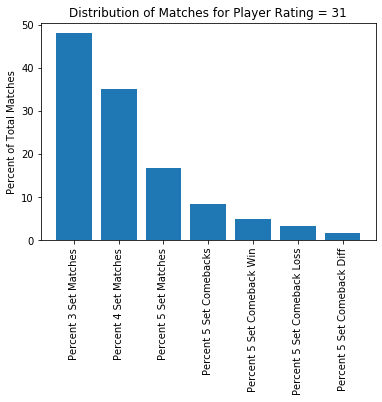

Percent 3 Set Matches          48.044693
Percent 4 Set Matches          35.195531
Percent 5 Set Matches          16.759777
Percent 5 Set Comebacks         8.379888
Percent 5 Set Comeback Win      5.027933
Percent 5 Set Comeback Loss     3.351955
Percent 5 Set Comeback Diff     1.675978
Name: 30, dtype: float64


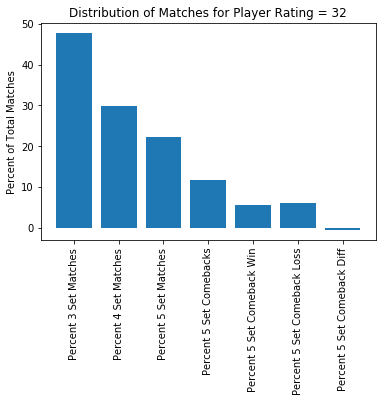

Percent 3 Set Matches          47.826087
Percent 4 Set Matches          29.813665
Percent 5 Set Matches          22.360248
Percent 5 Set Comebacks        11.801242
Percent 5 Set Comeback Win      5.590062
Percent 5 Set Comeback Loss     6.211180
Percent 5 Set Comeback Diff    -0.621118
Name: 31, dtype: float64


In [37]:
#Plot and pring all of the distributions for each player rating:
for ind in np.arange(32):
    
    plt.bar(np.arange(7),height=df_dist_ratings_all.iloc[ind,8:])
    plt.title(f'Distribution of Matches for Player Rating = {ind+1}')
    plt.ylabel('Percent of Total Matches')
    plt.xticks(np.arange(7),df_dist_ratings_all.columns[8:].values,rotation=90)
    plt.show() 
    print(df_dist_ratings_all.iloc[ind,8:])

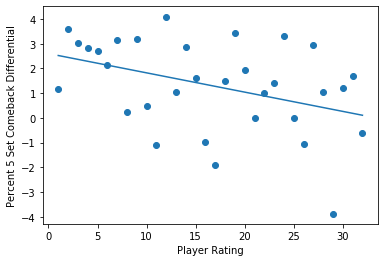

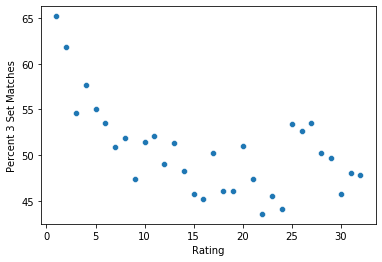

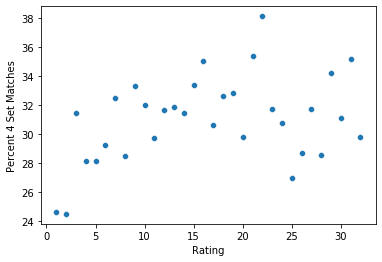

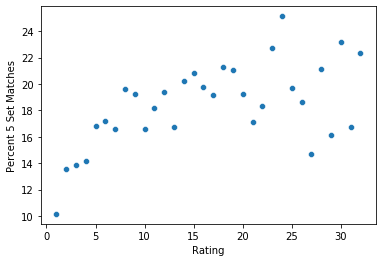

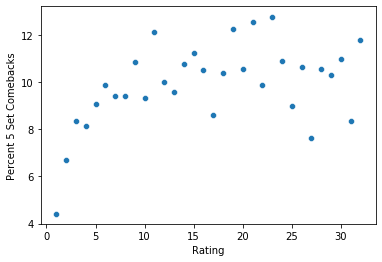

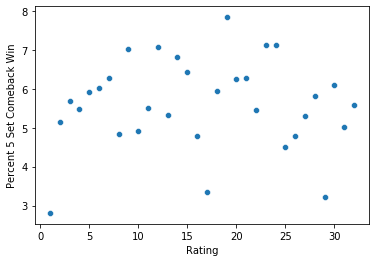

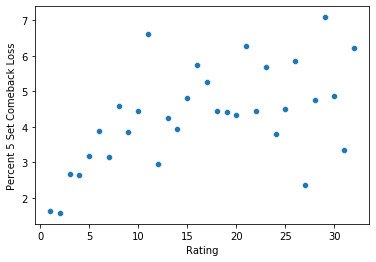

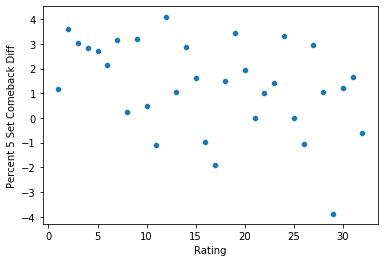

In [38]:
#Plot distribution quantities (e.g. 3 set matches, 5 set comebacks, etc.) vs. the Player Rating

x=df_dist_ratings_all['Rating']
y=df_dist_ratings_all['Percent 5 Set Comeback Diff']
plt.scatter(x,y)
plt.xlabel('Player Rating')
plt.ylabel('Percent 5 Set Comeback Differential')
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x))
plt.show()
df_dist_ratings_all['Percent 5 Set Comeback Diff'].mean()

for metric in df_dist_ratings_all.columns[8:]:
    sns.scatterplot(x='Rating',y=metric,data=df_dist_ratings_all)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


[63.12718786 25.2042007  11.66861144  5.25087515]
36
0.29133858267716534


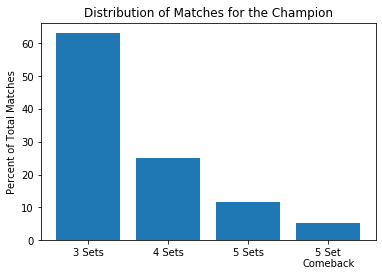

In [39]:
##### Distribution of matches for the champion and number of times champ would have lost if slam were best of 3
df_champ=pd.DataFrame()
champ_loss=0
#Get matches by looping through each slam and putting them all together in df_champ
for slam in df['Grand Slam'].unique():
    df_temp=df[df['Grand Slam']==slam]
    df_temp_final=df_temp[df_temp['Round']==7]
    champ=df_temp_final.apply(lambda x: x['Player 1'].split(' ')[-1] if x['Winner']==1 else x['Player 2'].split(' ')[-1],axis=1)
    champ=champ.values[0]
    df_temp['Champion']=champ
    df_temp=df_temp[((df_temp)['Player 1'].apply(lambda x: x.split(' ')[-1])==champ) | ((df_temp)['Player 2'].apply(lambda x: x.split(' ')[-1])==champ)]
    df_champ=df_champ.append(df_temp)
    if len(df_temp[df_temp['5-set Comeback']!=0])>0:
        champ_loss+=1
    else:
        pass

df_1=df_champ
sets_dist_1=df_1['# of Sets'].value_counts()[0:3].values
comeback_5sets_1=len(df_1[df_1['5-set Comeback']!=0])
sets_comeback_dist_1=np.append(sets_dist_1,comeback_5sets_1)/sum(sets_dist_1)*100
plt.bar(np.arange(4),height=sets_comeback_dist_1)
plt.xticks(np.arange(4),labels=xticks[0:4])
plt.ylabel('Percent of Total Matches')
plt.title('Distribution of Matches for the Champion')

print(sets_comeback_dist_1)
print(champ_loss)
print((champ_loss+1)/(len(df['Grand Slam'].unique())+2)) 

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

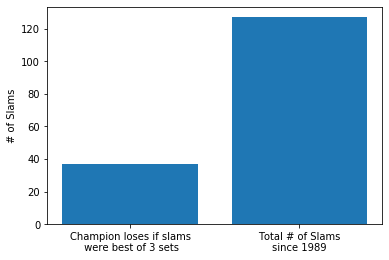

In [40]:
#Find the percent of times champ would have lost
champ_loss=37 #champ would have lost in 3 sets
slams=127

tick_label = ["Champion loses if slams\n were best of 3 sets","Total # of Slams\nsince 1989"] 
plt.bar([0,1], [champ_loss,slams], tick_label = tick_label, color = ['#1f77b4']) 
plt.ylabel('# of Slams')
plt.tight_layout
# plt.savefig('Figures/figure 1 Champion loses best of 3.png',dpi=1000)
# plt.savefig('Figures/figure 1 Champion loses best of 3.svg')

In [41]:
# Min and max percent of unfair champions (using p from #1 seed)
print(1-(1-.014)**7)
print(1-(1-0.044)**7)

0.09397870668170272
0.27019766940578505


In [42]:
def round_fair(r,perc):
    return (1-(1-perc)**(r-1))*100

print([round_fair(r,.04) for r in range(2,9)]) # Unfairness per round for everyone

[4.0000000000000036, 7.8400000000000025, 11.526400000000015, 15.065344000000014, 18.462730240000013, 21.724221030400017, 24.855252189184018]


In [43]:
#####Make data frame without matches between unrated players to evaluate fairness
df_rated=df[(df['Player 1 Rating']!=100) | (df['Player 2 Rating']!=100)]

In [44]:
#Make a column which only has the rating differential
def rating_diff(rate1,rate2):
    return abs(rate1-rate2)
#test rating_diff:
print(rating_diff(16,18))
print(rating_diff(18,16))

2
2


In [45]:
df['Rating Differential']=df.apply(lambda x: rating_diff(x['Player 1 Rating'],x['Player 2 Rating']),axis=1)

In [46]:
#Make a dataframe with only rated players and their differential
df_rated_diff=df[(df['Rating Differential']!=0) & (df['Rating Differential']<40)]

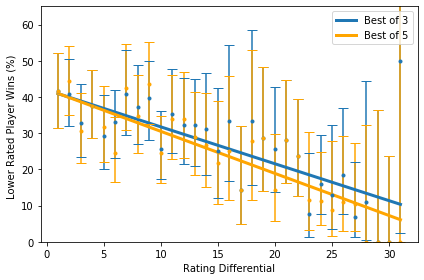

In [47]:
##### Plot lower rated player win % vs rating differential with 95% confidence intervals (binomial) on data points and linear fits 
##### using weights. Plot for 3 and 5 sets.
# Gets lower and upper error bars from confidence intervals (confidence intervals are binomial, so are asymmetric):
def error_bars(f):
    f['yerr-']=abs(f['CI'][0]-f['Percent Upsets']/100)*100
    f['yerr+']=abs(f['CI'][1]-f['Percent Upsets']/100)*100
    return f

#Define fitting function. Here a simple linear curve, but could be anything.
def f(x,m,b): 
    return m*x+b

fig=plt.figure(figsize=(6,4))
#loop through for 3 sets and 5 sets:
for name, color,alpha,legend in zip_longest(['Rated Winner 3','Rated Winner'],['#1f77b4','orange'],[1,1],['Best of 3','Best of 5']):
    diff_totals=df_rated_diff['Rating Differential'].value_counts() #Total number of data points (used in calculating CI) organized by the differential in rating
    low_diff_win5=df_rated_diff[df_rated_diff[name]==-1]['Rating Differential'].value_counts() # get all the wins for lower rated player organized by the differential in rating
    df_diff = pd.concat([diff_totals,low_diff_win5], axis=1, sort=False) #put total matches and wins (two above variables) into a df
    df_diff.fillna(0,inplace=True) #If there are no wins for the lower rated player, make this =0
    df_diff.columns=['Rating Differential Totals','Rating Differential Lower Rated Wins']
    df_diff['Percent Upsets']=df_diff.apply(lambda x: x['Rating Differential Lower Rated Wins']/x['Rating Differential Totals']*100,axis=1)
    df_diff['Rating Differential']=df_diff.index
    df_diff['Percent Upsets Smoothed']=df_diff['Percent Upsets'].rolling(center=False, window=3, min_periods=1).mean()
    df_diff['CI']=df_diff.apply(lambda x: proportion_confint(count=x['Rating Differential Lower Rated Wins'], nobs=x['Rating Differential Totals'], method='binom_test', alpha=0.05),axis=1)
    df_diff=df_diff.apply(error_bars,axis=1)
    #Plot rating differential vs Percent Upsets with fits and error bars
    plt.errorbar(x=df_diff['Rating Differential'],y=df_diff['Percent Upsets'],yerr=df_diff[['yerr-','yerr+']].T.values, linestyle="None",capsize=5,fmt='o',markersize=3,color=color,alpha=alpha)
    x=df_diff['Rating Differential']
    y=df_diff['Percent Upsets']
    df_diff['Uncertainty']=df_diff.apply(lambda x: x['yerr+'],axis=1)# #Make uncertainty column. Use only + side because - are small in binomial.
    sigma=df_diff['Uncertainty']/2 #Function accepts CI of 67%, but our confidence interval covers 95%.
    p0=-1,50 #Initialize parameters
    popt,pcov=curve_fit(f,x,y,p0,sigma=sigma,absolute_sigma=True)
    yfit=f(x,*popt)
    plt.plot(x, yfit, linewidth=3,color=color, label=legend)

    
plt.ylim([0,65])
plt.legend(loc='upper right')
plt.ylabel('Lower Rated Player Wins (%) ')
plt.xlabel('Rating Differential')
plt.tight_layout()
# plt.savefig('Figures/Upsets vs Rating Differential.png',dpi=1000)

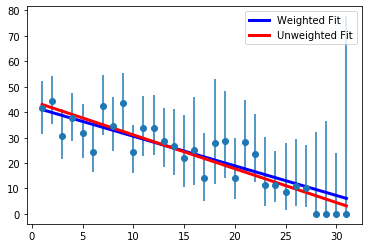

In [48]:
#Compare unweighted and weighted fits. Also, this tests before putting in loop above

from scipy.optimize import curve_fit

x=df_diff['Rating Differential']
y=df_diff['Percent Upsets']

def f(x,m,b): #Define fitting function. Here a simple linear curve, but could be anything.
    return m*x+b

df_diff['Uncertainty']=df_diff.apply(lambda x: x['yerr+'],axis=1)#x['yerr-']+x['yerr+'],axis=1) #Make uncertainty column. Use only + side because - are small in binomial.
sigma=df_diff['Uncertainty']/2 #Function accepts 1 standard deviation, but our confidence interval has 2...Divide by 2?...

p0=-1,50 #Initialize parameters
popt,pcov=curve_fit(f,x,y,p0,sigma=sigma,absolute_sigma=True)
yfit=f(x,*popt)

plt.errorbar(x=df_diff['Rating Differential'],y=df_diff['Percent Upsets'],yerr=df_diff[['yerr-','yerr+']].T.values, linestyle="None",fmt='o')
plt.plot(x, yfit, color='blue', linewidth=3, label='Best of 3 Fit')

#Unweighted, just to check:
p0=-1,50 #Initialize parameters
popt,pcov=curve_fit(f,x,y,p0)#,sigma=sigma,absolute_sigma=True) No uncertainty on values.
yfit=f(x,*popt)

# plt.errorbar(x=df_diff['Rating Differential'],y=df_diff['Percent Upsets'],yerr=df_diff[['yerr-','yerr+']].T.values, linestyle="None",fmt='o')
plt.plot(x, yfit, color='red', linewidth=3, label='Best of 3 Fit')
plt.legend(['Weighted Fit','Unweighted Fit'])

In [49]:
#Test that error bars work:
df_diff['CI']=df_diff.apply(lambda x: proportion_confint(count=x['Rating Differential Lower Rated Wins'], nobs=x['Rating Differential Totals'], method='binom_test', alpha=0.05),axis=1)

def error_bars(f):
    f['yerr-']=abs(f['CI'][0]-f['Percent Upsets']/100)*100
    f['yerr+']=abs(f['CI'][1]-f['Percent Upsets']/100)*100
    return f

df_diff=df_diff.apply(error_bars,axis=1)

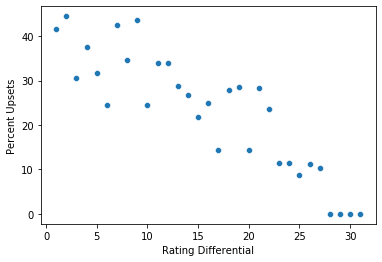

In [50]:
sns.scatterplot(x='Rating Differential',y='Percent Upsets',data=df_diff)

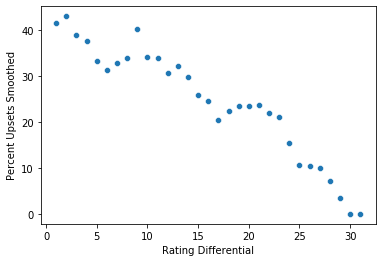

In [51]:
sns.scatterplot(x='Rating Differential',y='Percent Upsets Smoothed',data=df_diff)
# Interesting 3 bumps in data. Probably related to how the draws are made in grand slams since the draw is broken into
# 4 quarters. Could be removed if I had seeds for everyone.

In [52]:
# Function to make a column where if player 1 wins, 1, player 2 wins, -1 (after 1 set)
def win1(score1,score2):
    score1=np.array(score1)
    score2=np.array(score2)
    if len(score1)<1 or len(score2)<1:
        return 0
    if score1[0]>score2[0]:
        return 1
    else:
        return -1

win1([0],[])
win1([0,6,6,0],[6,0,0,6,6])
win1([6,0,6,0,0],[0,6,0,6,6])


1

In [53]:
df['Winner 1']=df.apply(lambda x: win1(x['Player 1 Score'],x['Player 2 Score']),axis=1)

In [54]:
#Function to make a column where the higher rated player wins after 1 set gets a 1, lower rated player gets a -1. two unrated players get a 0
def rate_win1(rate1,rate2,winner1):
    if winner1==0:
        return 0
    if winner1==1:
        if rate1>rate2:#player 2 rating higher rated than player 1 but player 1 wins, -1.
            return -1
        elif rate1<rate2:
            return 1
        else:
            return 0
    if winner1==-1:
        if rate1>rate2:
            return 1
        elif rate1<rate2:
            return -1
        else:
            return 0

In [55]:
df['Rated Winner 1']=df.apply(lambda x: rate_win1(x['Player 1 Rating'],x['Player 2 Rating'],x['Winner 1']),axis=1)

df_rated1=df[df['Rated Winner 1']!=0] #Remove unrated matchups and matches that didn't happen due to injury.

In [56]:
#Calculate the fraction of higher rated players who win the first set:
winner1_dist=df_rated1['Rated Winner 1'].value_counts().values
winner1_rated=winner1_dist[0]/sum(winner1_dist)
print(winner1_rated)

0.7043750699339824


In [57]:
#Minimum increase in fairness due to winning first set:
print(winner1_rated-(1-winner1_rated))

0.4087501398679647


In [58]:
# Make upper and lower bounds purely based on the decrease in fairness increase between 3 and 5 sets:
yhigh_alt=np.array([100,16.976,9.3078])
ylow_alt=np.array([40.9,5.6666,2.228])
for i in range(8):
    yhigh_alt=np.append(yhigh_alt,yhigh_alt[i+2]/(16.976/9.3078))
    ylow_alt=np.append(ylow_alt,ylow_alt[i+2]/(5.666/2.228))
print(yhigh_alt)
print(ylow_alt)

[1.00000000e+02 1.69760000e+01 9.30780000e+00 5.10338954e+00
 2.79814616e+00 1.53420033e+00 8.41189316e-01 4.61217125e-01
 2.52881524e-01 1.38652842e-01 7.60222035e-02]
[4.09000000e+01 5.66660000e+00 2.22800000e+00 8.76100247e-01
 3.44502533e-01 1.35466227e-01 5.32683999e-02 2.09463458e-02
 8.23657931e-03 3.23881022e-03 1.27357380e-03]


[100.      16.976    9.3078   6.83     5.25     4.04     3.11     2.4
   1.8      1.42     1.09  ]
[40.9         5.6666      2.228       0.95        0.43        0.19545455
  0.08884298  0.04038317  0.01835599  0.00834363  0.00379256]
[65.44       11.1090944   6.09102432  4.469552    3.4356      2.643776
  2.035184    1.57056     1.17792     0.929248    0.713296  ]
[81.2        11.25007139  4.4233154   1.88606357  0.85369193  0.38804179
  0.17638263  0.08017392  0.03644269  0.01656486  0.00752948]

Most likely increase in fairness by set (the mid bound): 
[69.7455     11.208087    5.710221    3.8511      2.8116      2.09655
  1.58342727  1.20798967  0.90008621  0.7070301   0.54142732]
ysum_upper: 152.2238
ysum_lower: 50.52977286731872
ysum_high: 99.61525472000002
ysum_low: 100.31827767301415
ysum_mid: 100.36301856932276


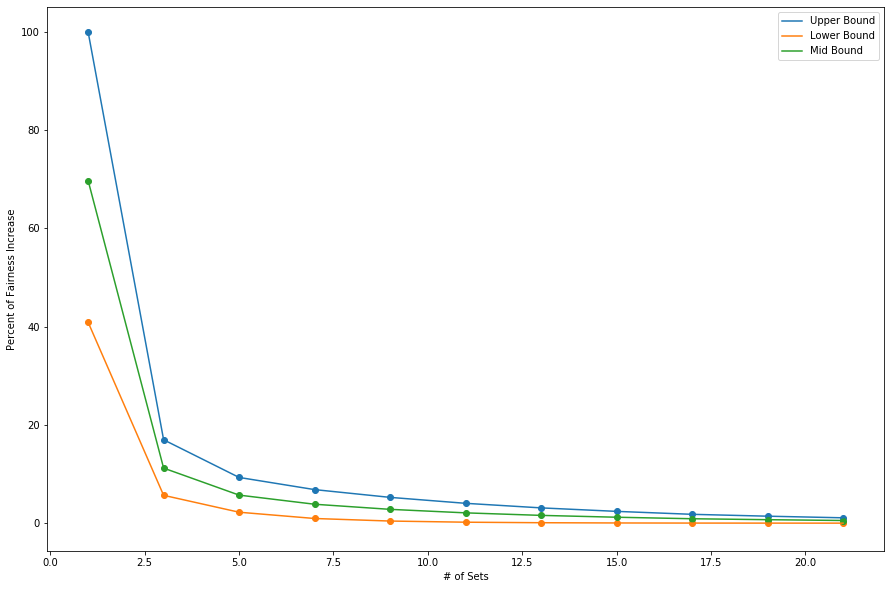

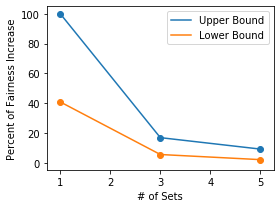

In [59]:
##### Plot upper and lower fairness bounds (with speculative higher set bounds using bayesian probabilities and some speculative mid bounds since fairness should add to 100).

plt.figure(figsize=(15,10))

x=np.arange(11)*2+1
xfit=np.linspace(1,11,500)

yhigh=np.array([100,16.976,9.3078,6.83,5.25,4.04,3.11,2.4,1.8,1.42,1.09]) #calculated using bayesian probabilities and some loose assumptions
ylow=np.array([40.9,5.6666,2.228,.95,.43,.43/2.2,.43/(2.2**2),.43/(2.2**3),.43/(2.2**4),.43/(2.2**5),.43/(2.2**6)]) #calculated using bayesian probabilities and some loose assumptions
# yhigh=yhigh_alt #Calculated 7+ set bounds by using 3 and 5 set ratio 
# ylow=ylow_alt #Calculated 7+ set bounds by using 3 and 5 set ratio. Seems to underestimate since mid doesn't sum to 100.
ymid_high=yhigh*40.9/70*1.12
ymid_low=ylow*70/40.9*1.16
ymid=np.mean([yhigh,ylow],axis=0)*.99 #Impressive that the average of the lower and upper bounds almost sum exactly to 100.
np.set_printoptions(suppress=True)
print(yhigh)
print(ylow)
print(ymid_high)
print(ymid_low)
print(f'\nMost likely increase in fairness by set (the mid bound): \n{ymid}')

#Plot all lower and upper and mid bounds. 7 sets and beyond are quite speculative.
plt.scatter(x, yhigh)
plt.scatter(x,ylow)
# plt.scatter(x,ymid_high)
# plt.scatter(x,ymid_low)
plt.scatter(x,ymid)

plt.plot(x, yhigh)
plt.plot(x,ylow)
# plt.plot(x,ymid_high)
# plt.plot(x,ymid_low)
plt.plot(x,ymid)

plt.xlabel('# of Sets')
plt.ylabel('Percent of Fairness Increase')
plt.legend(['Upper Bound','Lower Bound','Mid Bound'])
# plt.legend(['Upper Bound','Lower Bound','Mid-upper Bound','Mid-lower Bound','Mid Bound'])

ysum_upper=sum(yhigh)
ysum_lower=sum(ylow)
ysum_high=sum(ymid_high)
ysum_low=sum(ymid_low)
ysum_mid=sum(ymid)
print(f'ysum_upper: {ysum_upper}')
print(f'ysum_lower: {ysum_lower}')
print(f'ysum_high: {ysum_high}')
print(f'ysum_low: {ysum_low}')
print(f'ysum_mid: {ysum_mid}')

# print(yfit)
plt.show()

#Plot upper and lower bounds for blog:
plt.figure(figsize=(4,3))
plt.scatter(x[0:3], yhigh[0:3])
plt.plot(x[0:3], yhigh[0:3])
plt.scatter(x[0:3],ylow[0:3])
plt.plot(x[0:3],ylow[0:3])
plt.xlabel('# of Sets')
plt.ylabel('Percent of Fairness Increase')
plt.legend(['Upper Bound','Lower Bound'])
plt.tight_layout()
# plt.savefig('Figures/Figure 4 Upper and Lower Bounds.png', dpi=1000)

1.6749116607773853


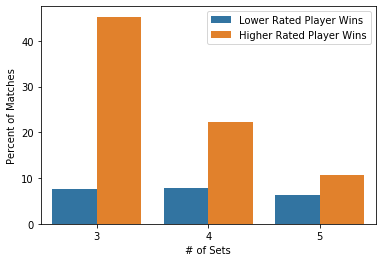

In [60]:
##### Figure 3: Plot the distribution of games won depending on if they are higher or lower rated:
df_rated=df_rated[df_rated['# of Sets']>2] 
# sns.countplot(x='# of Sets',data=df_rated,hue='Rated Winner')#Gives counts, not percentages
#Count plot with percentages:
ax = sns.barplot(x='# of Sets',y='# of Sets',data=df_rated, estimator=lambda x: len(x) / len(df_rated) * 100,hue='Rated Winner')
ax.set(ylabel="Percent of Matches")# ax.set_ylabel="Percent of Matches"
ax.legend((ax.get_legend_handles_labels()[0]),('Lower Rated Player Wins','Higher Rated Player Wins')) #Re-label legends.

#How much more likely are higher rated players to win the 5th set than lower rated ones?
df_rated_5_series=df_rated[df_rated['# of Sets']==5]['Rated Winner'].value_counts(normalize=True)
print(df_rated_5_series[1]/df_rated_5_series[-1])

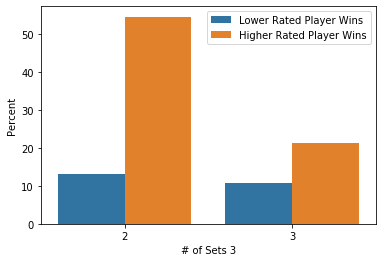

In [61]:
##### Figure (same as above figure 3 only 3-setters)
#Plot the distribution of games won for 3-setters depending on if they are higher or lower rated:

df_rated3=df_rated[df_rated['# of Sets']>1]
ax = sns.barplot(x='# of Sets 3',y='# of Sets 3',data=df_rated3, estimator=lambda x: len(x) / len(df_rated3) * 100,hue='Rated Winner 3')
ax.set(ylabel="Percent")
ax.get_legend_handles_labels()[0]
ax.legend((ax.get_legend_handles_labels()[0]),('Lower Rated Player Wins','Higher Rated Player Wins'))

In [62]:
df_rated3['# of Sets 3'].value_counts()/len(df_rated3['# of Sets 3'])

2    0.677109
3    0.322891
Name: # of Sets 3, dtype: float64

[1588  529 6384  341]
[17.95973762  5.98280932 72.20085953  3.85659353]


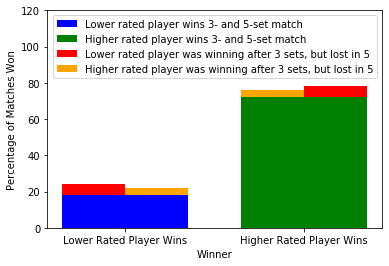

In [63]:
##### Plot All 5 set matches, but separate them by 5 set comebacks and whether the higher or lower rated player wins:
ww=len(df_rated[(df_rated['Rated Winner 3']==-1) & (df_rated['Rated Winner']==-1)])#Lower rated wins 3 and 5
wl=len(df_rated[(df_rated['Rated Winner 3']==-1) & (df_rated['Rated Winner']==1)])#Lower rated wins 3 but loses 5
ll=len(df_rated[(df_rated['Rated Winner 3']==1) & (df_rated['Rated Winner']==1)])#Lower rated loses 3 and 5
lw=len(df_rated[(df_rated['Rated Winner 3']==1) & (df_rated['Rated Winner']==-1)])#Lower rated loses 3 but wins 5
rated_totals=np.array((ww,wl,ll,lw))

# Print counts and percent:
print(rated_totals)
total=sum(rated_totals)/100
rated_totals_perc=rated_totals/total
print(rated_totals_perc)

# Plot all:
fig=plt.figure()
ax=fig.add_subplot(111)
width=0.35
b1=ax.bar([0,0+width],np.array((ww,ww))/total,width,color='blue')
b2=ax.bar([1,1+width],np.array((ll,ll))/total,width,color='green')
b3=ax.bar([0,1+width],np.array((wl,wl))/total,width,bottom=np.array((ww,ll))/total,color='red')
b4=ax.bar([width,1],np.array((lw,lw))/total,width,bottom=np.array((ww,ll))/total,color='orange')

ax.set_ylabel('Percentage of Matches Won')
ax.set_xlabel('Winner')
ax.set_xticks(np.array([0,1])+width/2)
ax.set_xticklabels( ('Lower Rated Player Wins', 'Higher Rated Player Wins') )
ax.set_ylim((0,120))
ax.legend((b1[0],b2[0],b3[0],b4[0]),('Lower rated player wins 3- and 5-set match',
                                    'Higher rated player wins 3- and 5-set match',
                                    'Lower rated player was winning after 3 sets, but lost in 5',
                                    'Higher rated player was winning after 3 sets, but lost in 5'))

In [64]:
#Get percentage of 3 and 5 set comebacks to use in figures below:
df_rated=df_rated[df_rated['# of Sets']>2] 
df_rated3=df_rated[df_rated['# of Sets']>1] 
comeback5_total=sum(df_rated['Rated 5-set Comeback'].value_counts(normalize=True)[1:3])
comeback3_total=sum(df_rated3['Rated 3-set Comeback'].value_counts(normalize=True)[1:3])

[[Text(0, 0, 'Lower Rated Player Wins'),
  Text(0, 0, 'Higher Rated Player Wins')]]

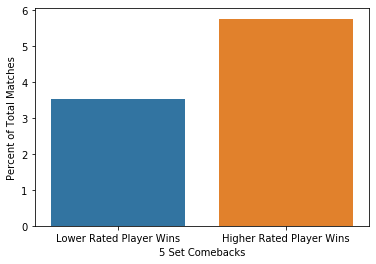

In [65]:
##### Plot increase in fairness for each match thanks to 5-setters
df5set_rated=df[df['Rated 5-set Comeback']!=0]
df5set_rated['Rated 5-set Comeback'].value_counts() # plot this in percentages

##### Figure 
#Count plot with percentages:
ax=plt.figure()
ax = sns.barplot(x='Rated 5-set Comeback',y='Rated 5-set Comeback',data=df5set_rated, estimator=lambda x: len(x) / len(df5set_rated) * comeback5_total*100)
ax.set(ylabel="Percent of Total Matches")
ax.set(xlabel="5 Set Comebacks")
ax.set(xticklabels=['Lower Rated Player Wins','Higher Rated Player Wins'])

[[Text(0, 0, 'Lower Rated Player Wins'),
  Text(0, 0, 'Higher Rated Player Wins')]]

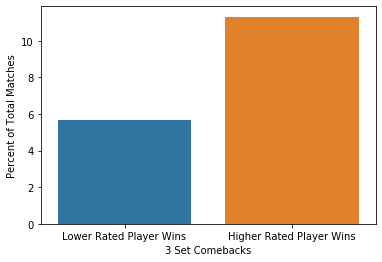

In [66]:
##### Plot increase in fairness for 3 sets:
df3set_rated=df[df['Rated 3-set Comeback']!=0]

ax=plt.figure()
ax = sns.barplot(x='Rated 3-set Comeback',y='Rated 3-set Comeback',data=df3set_rated, estimator=lambda x: len(x) / len(df3set_rated) * comeback3_total*100)
ax.set(ylabel="Percent of Total Matches")
ax.set(xlabel="3 Set Comebacks")
ax.set(xticklabels=['Lower Rated Player Wins','Higher Rated Player Wins'])

1.6749116607773853


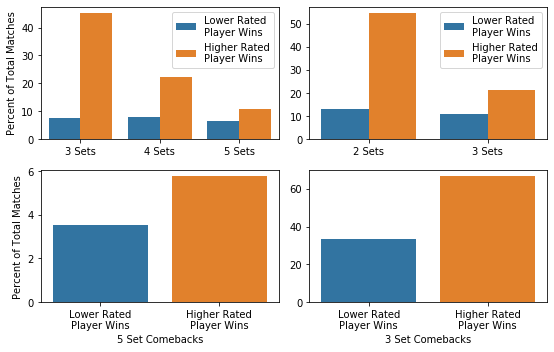

In [67]:
##### Figure 3
#Plot the distribution of games won depending on if they are higher or lower rated (all 4 figures plotted above in one figure)
fig, ax =  plt.subplots(2,2,sharey=False,figsize=(7.8,5))

#Upper left figure: distribution of games won for 5-setters depending on if they are higher or lower rated:
ax[0,0] = sns.barplot(x='# of Sets',y='# of Sets',data=df_rated, estimator=lambda x: len(x) / len(df_rated) * 100,hue='Rated Winner',ax=ax[0,0])
ax[0,0].set(ylabel="Percent of Total Matches")
ax[0,0].get_legend_handles_labels()[0]
ax[0,0].legend((ax[0,0].get_legend_handles_labels()[0]),('Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'))
ax[0,0].set_xticklabels(['3 Sets','4 Sets','5 Sets'])
ax[0,0].set_xlabel('')

#How much more likely are higher rated players to win the 5th set than lower rated ones?
df_rated_5_series=df_rated[df_rated['# of Sets']==5]['Rated Winner'].value_counts(normalize=True)
print(df_rated_5_series[1]/df_rated_5_series[-1])

##### Upper right figure: distribution of games won for 3-setters depending on if they are higher or lower rated:
ax[0,1] = sns.barplot(x='# of Sets 3',y='# of Sets 3',data=df_rated3, estimator=lambda x: len(x) / len(df_rated3) * 100,hue='Rated Winner 3',ax=ax[0,1])
ax[0,1].set(ylabel="")
ax[0,1].get_legend_handles_labels()[0]
ax[0,1].legend((ax[0,1].get_legend_handles_labels()[0]),('Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'))
ax[0,1].set_xticklabels(['2 Sets','3 Sets'])
ax[0,1].set_xlabel('')

#### Lower left figure: 5 set comebacks for higher and lower seeds
ax[1,0] = sns.barplot(x='Rated 5-set Comeback',y='Rated 5-set Comeback',data=df5set_rated, estimator=lambda x: len(x) / len(df5set_rated)*comeback5_total*100 ,ax=ax[1,0])
ax[1,0].set(ylabel="Percent of Total Matches")
ax[1,0].set(xlabel="5 Set Comebacks")
ax[1,0].set(xticklabels=['Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'])

##### Lower right figure: 3 set comebacks for higher and lower seeds:
ax[1,1] = sns.barplot(x='Rated 3-set Comeback',y='Rated 3-set Comeback',data=df3set_rated, estimator=lambda x: len(x) / len(df3set_rated) *100 ,ax=ax[1,1])
ax[1,1].set(ylabel="")
ax[1,1].set(xlabel="3 Set Comebacks")
ax[1,1].set(xticklabels=['Lower Rated\nPlayer Wins','Higher Rated\nPlayer Wins'])

# Save figures:
plt.tight_layout()
# fig.savefig('Figures/figure 4 Rated Players Breakdown best of 3 and best of 5 and comebacks.png',dpi=1500)
# fig.savefig('Figures/figure 4 Rated Players Breakdown best of 3 and best of 5 and comebacks.svg')

In [68]:
###### Lower and upper 5 set comeback bounds:
print(df_rated['Rated 5-set Comeback'].value_counts()/len(df_rated['Rated Winner']))

comeback5_prop=df_rated['Rated 5-set Comeback'].value_counts()/len(df_rated['Rated Winner'])
print(comeback5_prop[1]-comeback5_prop[-1]) 
print(comeback5_prop[1]+comeback5_prop[-1])

 0    0.906922
 1    0.057679
-1    0.035399
Name: Rated 5-set Comeback, dtype: float64
0.022280027143180274
0.09307848902963131


In [69]:
###### Lower and upper 3 set comeback bounds:
print(df_rated3['Rated 3-set Comeback'].value_counts()/len(df_rated3))

comeback3_prop=df_rated3['Rated 3-set Comeback'].value_counts()/len(df_rated['Rated Winner'])
print(comeback3_prop[1]-comeback3_prop[-1]) 
print(comeback3_prop[1]+comeback3_prop[-1])

 0    0.830242
 1    0.113210
-1    0.056548
Name: Rated 3-set Comeback, dtype: float64
0.05666138882605745
0.16975797330920606


In [70]:
# Rated 5 set distribution:
print(df_rated['# of Sets'].value_counts()/len(df_rated))

3    0.528274
4    0.300498
5    0.171228
Name: # of Sets, dtype: float64


In [71]:
# Rated 3 set distribution:
print(df_rated3['# of Sets 3'].value_counts()/len(df_rated3))

2    0.677109
3    0.322891
Name: # of Sets 3, dtype: float64


In [72]:
df_inj=df[(df['Player 1 Score'].apply(len)!=df['Player 2 Score'].apply(len)) & (df['Round']!=1)]#All injured playes
df_inj_round=df[(df['Player 1 Score'].apply(len)!=df['Player 2 Score'].apply(len)) & (df['Round']!=0)]['Round'].value_counts()#Number of players that retire by round.
print(f'Total injured matches by round:\n{df_inj_round}')
df_round=df['Round'].value_counts()
print(f'Total matches by round: \n{df_round}')
print(f'Fraction of players that retire by round: \n{df_inj_round/df_round}') #Fraction of players that retire by round
print(f'Fraction of players that retire from tournament: \n{sum(df_inj_round)/sum(df_round)}') # Fraction of players that retire from the tournament:

Total injured matches by round:
1    267
2     88
3     64
4     23
5     12
6      5
7      1
Name: Round, dtype: int64
Total matches by round: 
1    7999
2    3977
3    1991
4     995
5     498
6     249
7     125
Name: Round, dtype: int64
Fraction of players that retire by round: 
1    0.033379
2    0.022127
3    0.032145
4    0.023116
5    0.024096
6    0.020080
7    0.008000
Name: Round, dtype: float64
Fraction of players that retire from tournament: 
0.02905140836175319


In [73]:
##### Get the total number of sets in the match before a player gets injured:
sets_before_inj=[]
for index, row in df_inj.iterrows():
    slam=row['Grand Slam']
    round_before=row['Round']-1
    if row['Player 1 Score']<row['Player 2 Score']:
        player=row['Player 1'].split(' ')[-1]
    else:
        player=row['Player 2'].split(' ')[-1]
    sets_before_inj_1=df[(df['Grand Slam']==slam) & (df['Round']==round_before) & ((df['Player 1'].apply(lambda x: x.split(' ')[-1])==player) | (df['Player 2'].apply(lambda x: x.split(' ')[-1])==player))]['# of Sets']
    sets_before_inj.append(sets_before_inj_1.array[0])


np.array(sets_before_inj)
counts=np.bincount(sets_before_inj)
print(f'# of sets played in round before injury: \n{counts}')

# of sets played in round before injury: 
[ 0  0  1 88 52 52]


Text(0.5, 1.0, 'Length of Match before Injury')

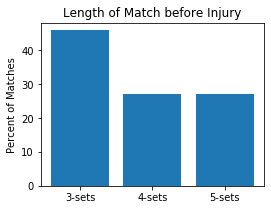

In [74]:
######## Plot percentages WITHOUT total matches
perc_counts=counts[3:]/sum(counts[3:])

fig=plt.figure(figsize=(4,3))
left = [1, 2, 3] #position of bars in bar graph
plt.bar(x=left,tick_label=['3-sets','4-sets','5-sets'],height=perc_counts*100)
plt.ylabel('Percent of Matches')
plt.title('Length of Match before Injury')

[49.42307692 31.43589744 19.14102564]


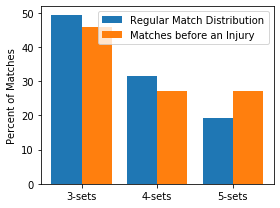

In [75]:
#####Plot distribution of sets regular and in the matches before an injury:
fig=plt.figure(figsize=(4,3))
width=.4

#Regular distribution:
sets_dist=df['# of Sets'].value_counts()[0:3].values
plt.bar(np.arange(3)-width,width=width,height=sets_dist/sum(sets_dist)*100)
print(sets_dist/sum(sets_dist)*100)

#Distribution of sets before an injury
plt.bar(np.arange(3),width=width,height=perc_counts*100)
plt.xticks(np.arange(3)-width/2,['3-sets','4-sets','5-sets'])
plt.ylabel('Percent of Matches')
plt.legend(['Regular Match Distribution','Matches before an Injury'])
plt.tight_layout()
# plt.savefig('Figures/Figure 4 Length of Match before Injury.png',dpi=1000)

43
33.85826771653544


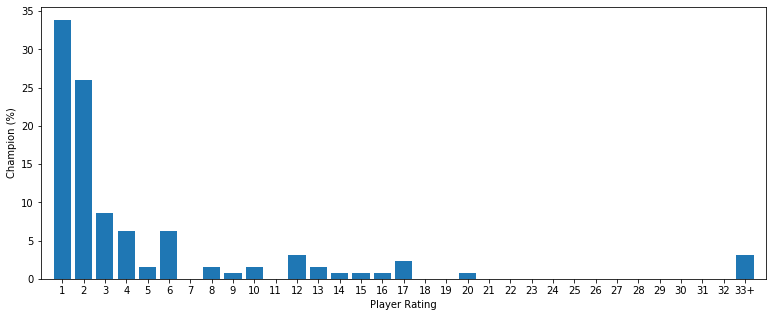

In [76]:
##### Plot the number of times each seed has won a slam
df['Winner Rating']=df.apply(lambda x: x['Player 1 Rating'] if x['Winner']==1 else x['Player 2 Rating'],axis=1)#Makes a column with the player rating who won the match

df_finals=df[df['Round']==7] #Get only the final match

rating_slam_wins=df_finals['Winner Rating'].value_counts()
rating_slam_wins[2]+=2
rating_slam_wins.index
rating_slam_wins = rating_slam_wins.rename(index={100: 33})

# Plot percentage of slam wins by rating:
plt.figure(figsize=(13,5))
plt.bar(x=rating_slam_wins.index,height=rating_slam_wins/sum(rating_slam_wins)*100)
plt.xlabel('Player Rating')
plt.ylabel('Champion (%)')
l=list(range(1,33))
l.append('33+')
plt.xticks(np.arange(1,34),l)
plt.xlim((0,34))
print(rating_slam_wins[1])
print(rating_slam_wins[1]/sum(rating_slam_wins)*100)

In [77]:
#Which are the players who were rated over 32? Aside: in the '94 us open, players outside top 16 weren't rated.
df_finals[df_finals['Winner Rating']==100]
#Agassi was 20th (but unrated) https://www.nytimes.com/1994/09/12/sports/us-open-94-the-new-agassi-style-now-has-substance.html
#Kuerten 66 
#Ivanisevic was 125
#Gaudio was 44

,Grand Slam,Round,Player 1 Rating,Player 1,Player 1 Score,Player 2 Rating,Player 2,Player 2 Score,5-set Comeback,3-set Comeback,...,Winner 3,Rated Winner 3,# of Sets,# of Sets 3,Rated 5-set Comeback,Rated 3-set Comeback,Rating Differential,Winner 1,Rated Winner 1,Winner Rating
2794,1994 u,7,4,Michael Stich,"[1, 65, 5]",100,Andre Agassi,"[6, 77, 7]",0,0,...,-1,-1,3,2,0,0,96,-1,-1,100
4191,1997 f,7,100,Gustavo Kuerten,"[6, 6, 6]",16,Sergi Bruguera,"[3, 4, 2]",0,0,...,1,-1,3,2,0,0,84,1,-1,100
6477,2001 w,7,100,Goran Ivanišević,"[6, 3, 6, 2, 9]",3,Pat Rafter,"[3, 6, 3, 6, 7]",0,0,...,1,-1,5,3,0,0,97,1,-1,100
7747,2004 f,7,100,Gastón Gaudio,"[0, 3, 6, 6, 8]",3,Guillermo Coria,"[6, 6, 4, 1, 6]",1,0,...,-1,1,5,2,-1,0,97,-1,1,100
